Беховский М.А. Предсказание появления ребер в темпоральном графе

In [1]:
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
import math
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

Input file format (edgelist): 

u   v   w   t

Third column (w) is being ignored. 

Constructor creates networkx multigraph, static version of multigraph, training multigraph slice, static version of the slice.

If input graph doesn't have multi-edges, analyzer hardsets to persistent mode (IIB in the Bruin's article), since there is no point in past event aggregation.

If graph has multiedges, it's possible to manually switch between discrete events mode (IIA, which considers past event aggregation) and persistent mode (IIB, ignoring aggregation and considering only the latest timestamp among multiedges)

Then it selects possible candidates -- node pairs at distance 2 in the slice. Selecting candidates may take some time since it requires finding shortest paths lengths for all node pairs.

In [2]:
class GraphAnalyzer():
    def __init__(self, fpath, 
    tw=['lin', 'exp', 'sqrt'], 
    pea=['0-q', '1-q', '2-q', '3-q', '4-q', 'sum', 'mean', 'var'],
    wtf=['aa','cn','jc','pa'],
    s = 2/3):
        with open(fpath) as f:
            edgelist = f.readlines()
        edgelist = [edge.strip().split() for edge in edgelist]

        # this sorting is needed to create training slice while constructing analyzer.
        edgelist.sort(key=lambda e: int(e[3]))
        self.slice_border = float(edgelist[int(s * len(edgelist))][3])
        print(f'Total number of edges {len(edgelist)}')
        Gr = nx.MultiGraph()
        Gsliced = nx.MultiGraph()
        
        # static graph variants
        GrS = nx.Graph()
        GslicedS = nx.Graph()

        # lowest and highest timestamps are needed for temporal feature extraction
        t_ma = 0.
        t_mi = float('inf')

        # reading Graphs from file
        for edge in edgelist:
            u = int(edge[0])
            v = int(edge[1])
            # no self-loops!
            if u != v:
                ts = float(edge[3])
                if ts < t_mi:
                    t_mi = ts
                if ts > t_ma:
                    t_ma = ts
                Gr.add_edge(u,v, t = ts)
                if u not in GrS or v not in GrS[u]:
                    GrS.add_edge(u,v)
                if ts <= self.slice_border:
                    Gsliced.add_edge(u, v, t=ts)
                    if u not in GslicedS or v not in GslicedS[u] or GslicedS[u][v]['t'] < ts:
                        GslicedS.add_edge(u,v, t = ts)

        # check for multi edges
        self.hard_persistent = True
        for u in Gsliced:
            for v in Gsliced[u]:
                if len(Gsliced[u][v]) > 1:
                    self.hard_persistent = False
        self.persistent = self.hard_persistent

        self.G = Gr
        self.G_static = GrS
        self.G_slice = Gsliced
        self.G_slice_static = GslicedS

        self.t_max = t_ma
        self.t_min = t_mi

        self.temporal_weighting_variants = tw
        self.past_event_aggregation_variants = pea
        self.weighted_topological_feature_variants = wtf

        # list of node-pairs with distance 2 between them
        # in training slice
        self.candidates = []
        checked = set()
        self.cand_labels = []
        paths = dict(nx.all_pairs_shortest_path_length(GslicedS, cutoff=2))
        for u in tqdm(paths):
            for v in tqdm(paths[u], leave=False):
                if paths[u][v] == 2 and (v,u) not in checked:
                    checked.add((u,v))
                    self.candidates.append((u,v))
                    if v in self.G[u]:
                        self.cand_labels.append(1)
                    else:
                        self.cand_labels.append(0)
        self.examples = []
        self.ex_labels = []
        self.ex_static_features = []
        self.ex_temp_features = []
        
    def switch_persistence(self):
        if self.hard_persistent:
            print('Persistent by graph. Can\'t be changed')
        elif self.persistent:
            self.persistent=False
            print('Warning. Manually switched to discrete events mode. Computations will take significantly longer but may be more accurate')
        else:
            self.persistent = True
            print('Warning. Manually switched to persistent mode. Computations will take significantly shorter but may be less accurate')

#######################################################
# static network features. displaying some features of whole graph. first part of the task
#######################################################
    def explore_graph(self):
        G = self.G_static
        ed_num = len(self.G_static.edges())
        n_num = len(self.G_static)
        density = 2 * ed_num / n_num / (n_num - 1)
        cc = list(nx.connected_components(self.G_static))
        cc_num = len(cc)
        largest_cc = max(cc, key=len)
        cc_dens = len(largest_cc) / n_num
        H = G.subgraph(largest_cc).copy()
        print(f' Статический граф: ')
        print(f' Вершин: {n_num}\n Ребер: {ed_num} \n Плотность: {density}')
        print(f' Компонент связности: {cc_num}\n Доля вершин в максимальной по мощности компоненте связности: {cc_dens}')
        
        if len(H.nodes()) > 1000:
            print('Snowball')
            snowballs = [0.] * 10
            for i in range(len(snowballs)):
                snowball = nx.Graph()
                snowflakes = set()
                snowflake = random.choice(list(H.nodes()))
                while len(snowball.nodes()) < 1000:
                    for v in H[snowflake]:
                        if v not in snowball:
                            snowflakes.add(v)
                            snowball.add_edge(snowflake, v)
                    snowflake = random.choice(list(snowflakes))
                snowballs[i] = snowball
            R = 0.
            diam = 0.
            dist_90 = 0.
            for i in range(len(snowballs)):
                R += nx.radius(snowballs[i])
                diam += nx.diameter(snowballs[i])
                dists = dict(nx.all_pairs_shortest_path_length(snowballs[i]))
                Dists = []
                checked = set()
                for u in dists:
                    for v in dists[u]:
                        if (v,u) not in checked:
                            checked.add((u,v))
                            Dists.append(dists[u][v])
                Dists.sort()
                dist_90 += Dists[90 * len(Dists) // 100]
            R /= 10
            diam /= 10
            dist_90 /= 10
        else:
            print('Honest')
            R = nx.radius(H)
            diam = nx.diameter(H)
            dists = dict(nx.all_pairs_shortest_path_length(H))
            Dists = []
            checked = set()
            for u in dists:
                for v in dists[u]:
                    if (v,u) not in checked:
                        checked.add((u,v))
                        Dists.append(dists[u][v])
            Dists.sort()
            dist_90 = Dists[90 * len(Dists) // 100]
        print(f' Наибольшая компонента связности: \n 1.Радиус {R}\n 2.Диаметр {diam}\n 3.90 процентиль расстояния: {dist_90}')

        Cl = nx.average_clustering(G)
        print(f' Средний кластерный коэффициент: {Cl}')

        r = nx.degree_pearson_correlation_coefficient(G)
        print(f' Коэффициент ассортативности {r}')
#######################################################
# sampling the candidates list for 10000
# pairs which will be connected
# and 10000 which won't be (if sampling without replacement it chooses the lesser class size instead)
# can be used to initiate and refresh example-label lists
#######################################################
    def sample(self, replace=True):
        self.examples = []
        self.ex_labels = []
        self.ex_static_features = []
        self.ex_temp_features = []
        # indices
        connected = []
        disconnected = []

        selection=[]

        for i in range(len(self.cand_labels)):
            if self.cand_labels[i] == 1:
                connected.append(i)
            else:
                disconnected.append(i)
        
        print(f' Number of candidates {len(self.cand_labels)}')
        print(f' Number of candidates which will be connected {len(connected)}')
        print(f' Number of candidates which will remain unconnected {len(disconnected)}')
        
        if replace:
            selection += random.choices(connected, k = 10000) + random.choices(disconnected, k=10000)
        else:
            if len(connected) > 10000 and len(disconnected) > 10000:
                selection += random.sample(connected, 10000) + random.sample(disconnected, 10000)
            elif len(connected) < len(disconnected):
                selection += connected + random.sample(disconnected, len(connected))
            else:
                selection += disconnected + random.sample(connected, len(disconnected))
            
        for i in selection:
            self.examples.append(self.candidates[i])
            self.ex_labels.append(self.cand_labels[i])
        print(f'Example set is of size {len(self.examples)}')

    def calc_features(self, type='static'):
        if type == 'static':
            self.ex_static_features = []
        elif type == 'temporal':
            self.ex_temp_features = []
        if len(self.examples) == 0:
            print('First sample candidates!')
        else:
            # optimization due to examples containing similar pairs
            checked = dict()
            for ex in tqdm(self.examples):
                if ex not in checked:
                    if type == 'static':
                        feature = self.static_feature(ex[0], ex[1])
                        self.ex_static_features.append(feature)    
                    elif type == 'temporal':
                        feature = self.temporal_feature(ex[0], ex[1])
                        self.ex_temp_features.append(feature)
                    checked[ex] = feature
                else:
                    feature = checked[ex]
                    if type == 'static':
                        self.ex_static_features.append(feature)
                    elif type == 'temporal':
                        self.ex_temp_features.append(feature)
            print(f'{type} features calculated')
    
# experimental functions. 
    def calc_features_all_cands(self):
        self.examples = []
        self.ex_labels = []
        self.ex_static_features = []
        self.ex_temp_features = []
        for i in range(len(self.candidates)):
            self.examples.append(self.candidates[i])
            self.ex_labels.append(self.cand_labels[i])
        self.calc_features()

    def calc_all_features(self):
        self.calc_features(type='static')
        self.calc_features(type='temporal')

#######################################################
# prediction and scoring using logistic regression
#######################################################
    def predict(self, type='static'):
        if type == 'static':
            X_train, X_test, y_train, y_test = train_test_split(self.ex_static_features, self.ex_labels)
        elif type == 'temporal':
            X_train, X_test, y_train, y_test = train_test_split(self.ex_temp_features, self.ex_labels)
        scaler_tr = StandardScaler().fit(X_train+X_test)
        X_train = scaler_tr.transform(X_train)
        clf = LogisticRegression().fit(X_train, y_train)
        X_test = scaler_tr.transform(X_test)
        y_pred = clf.predict_proba(X_test)
        y_pred = y_pred[:,1]
        return y_pred, y_test
    
    def ROC_score(self, y_pred, y_test):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        score = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % score)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        return score
    
    def analysis(self, type='static'):
        y_p, y_t = self.predict(type)
        return self.ROC_score(y_p, y_t)

# one button solution for created analyzer
    def obs(self, type='static', exp=False, replace=True):
        if exp and type == 'static':
            self.calc_features_all_cands()
        else:
            self.sample(replace=replace)
            self.calc_features(type)
        return self.analysis(type)

#######################################################
# static features. computed on static (undirected, w/o parallel edges, w/o timestamps) graph variant
# static feature of a node pair is a 4-component vector consisting of following metrics:
# 1. number of common neighbours
# 2. Adamic-Adar index
# 3. Jaccard coefficient
# 4. Preferential attachment metric
# as they are defined, among other sources, in networkX library
#######################################################
    def static_feature(self, u, v):
        feature = [0.] * 4
        # common neighbours component
        feature[0] = len(list(nx.common_neighbors(self.G_slice_static, u, v)))
        # failsafe
        if feature[0] == 0:
            feature[1] = 0
            feature[2] = 0
        else:
            # adamic-adar component
            feature[1] = list(nx.adamic_adar_index(self.G_slice_static, [(u,v)]))[0][2]
            # jaccard coefficient component
            feature[2] = list(nx.jaccard_coefficient(self.G_slice_static, [(u,v)]))[0][2]
        # preferential attachment component
        feature[3] = list(nx.preferential_attachment(self.G_slice_static, [(u,v)]))[0][2]
        return feature


#######################################################
# temporal features. edge activity with (event graph) or without (persistent graph) past event aggregation
# temporal feature of a node pair in event is a 96 component vector
# temporal feature of a node pair in persistent is a 12 component vector
# which consists of all possible combinations for calculating 
# weighted topological feature as given in the article
# (3 temporal weighting methods x 8 aggregation functions x 4 weighted features) event
# (3 twm x 4 wtf) persistent
# where weighted features accord to static metrics (CN, AA, JC, PA generalized for weighted case)
#######################################################
    def temporal_weighting(self, u, v, i=None, tw_type='lin'):
        if self.persistent:
            t = self.G_slice_static[u][v]['t']
        else:
            t = self.G_slice[u][v][i]['t']
        T = (t - self.t_min)/(self.t_max - self.t_min)
        if tw_type == 'lin':
            return 0.2 + 0.8 * T
        elif tw_type == 'exp':
            return 0.2 + 0.8 * (math.exp(3*T) - 1)/(math.e ** 3 - 1)
        elif tw_type == 'sqrt':
            return 0.2 + 0.8 * math.sqrt(T)

    # past event aggregation with respect to example sourcing slice 
    # upper timestamp
    def past_event_aggregation(self, u, v, pea_type, tw_type):
        if self.persistent:
            return 'Some error. This graph doesnt need aggregation'
        weights = []
        weightsum = 0.
        for i in self.G_slice[u][v]:
            weight = self.temporal_weighting(u,v,i,tw_type)
            weights.append(weight)
            weightsum += weight
        weights.sort()
        n = len(weights)
        if pea_type == 'sum':
            return weightsum
        elif pea_type == 'mean':
            return weightsum / n
        elif pea_type == 'var':
            mean = weightsum / n
            variance = 0.
            for w in weights:
                variance += (w - mean) ** 2
            return variance / n 
        elif pea_type == '0-q':
            return weights[0]
        elif pea_type == '1-q':
            return weights[n // 4]
        elif pea_type == '2-q':
            return weights[n // 2]
        elif pea_type == '3-q':
            return weights[3 * n // 4]
        elif pea_type == '4-q':
            return weights[n - 1]
        else:
            return 'Unknown PEA descriptor'

    # calculate temporal feature vector for a node-pair.
    # if analyzer is in persistent mode, it returns 12-component vector
    # which corresponds to IIB method in the article
    # otherwise it returns 96 components vector according to IIA method    
    def temporal_feature(self, u, v):
        f = []
        if not self.persistent:
            for tw in self.temporal_weighting_variants:
                for ag in self.past_event_aggregation_variants:
                    for w in self.weighted_topological_feature_variants:
                        if w == 'cn':
                            combo = 0.
                            for z in nx.common_neighbors(self.G_slice_static, u, v):
                                combo += self.past_event_aggregation(u,z,ag,tw) +\
                                    self.past_event_aggregation(v,z,ag,tw)
                        elif w == 'aa':
                            combo = 0.
                            for z in nx.common_neighbors(self.G_slice_static, u, v):
                                den = self.past_event_aggregation(u,z,ag,tw) +\
                                    self.past_event_aggregation(v,z,ag,tw)
                                z_wtf = 0.
                                for x in self.G_slice_static[z]:
                                    z_wtf += self.past_event_aggregation(z, x, ag, tw)
                                divisor = math.log(1 + z_wtf)
                                if divisor == 0:
                                    combo += 0.
                                else:
                                    combo += den / divisor
                        elif w == 'jc':
                            combo = 0.
                            for z in nx.common_neighbors(self.G_slice_static, u, v):
                                den = self.past_event_aggregation(u,z,ag,tw) +\
                                    self.past_event_aggregation(v,z,ag,tw)
                                u_wtf = 0.
                                for x in self.G_slice_static[u]:
                                    u_wtf += self.past_event_aggregation(u,x,ag,tw)
                                v_wtf = 0.
                                for y in self.G_slice_static[v]:
                                    v_wtf += self.past_event_aggregation(v,y,ag,tw)
                                divisor = u_wtf + v_wtf
                                if divisor == 0:
                                    combo += 0.
                                else:
                                    combo += den / divisor
                        elif w == 'pa':
                            u_wtf = 0.
                            for x in self.G_slice_static[u]:
                                u_wtf += self.past_event_aggregation(u,x,ag,tw)
                            v_wtf = 0.
                            for y in self.G_slice_static[v]:
                                v_wtf += self.past_event_aggregation(v,y,ag,tw)
                            combo = u_wtf * v_wtf
                        else:
                            combo = 0.
                            print('Unknown WTF descriptor')
                        f.append(combo)
        else:
            for tw in self.temporal_weighting_variants:
                for w in self.weighted_topological_feature_variants:
                    if w == 'cn':
                        combo = 0.
                        for z in nx.common_neighbors(self.G_slice_static, u, v):
                            combo += self.temporal_weighting(u,z,tw) +\
                                    self.temporal_weighting(z,v,tw)
                    elif w == 'aa':
                        combo = 0.
                        for z in nx.common_neighbors(self.G_slice_static, u, v):
                            den = self.temporal_weighting(u,z,tw) +\
                                    self.temporal_weighting(v,z,tw)
                            z_wtf = 0.
                            for x in self.G_slice_static[z]:
                                z_wtf += self.temporal_weighting(z, x, tw)
                            divisor = math.log(1 + z_wtf)
                            if divisor == 0:
                                combo += 0.
                            else:
                                combo += den / divisor
                    elif w == 'jc':
                        combo = 0.
                        for z in nx.common_neighbors(self.G_slice_static, u, v):
                            den = self.temporal_weighting(u,z,tw) +\
                                    self.temporal_weighting(v,z,tw)
                            u_wtf = 0.
                            for x in self.G_slice_static[u]:
                                u_wtf += self.temporal_weighting(u,x,tw)
                            v_wtf = 0.
                            for y in self.G_slice_static[v]:
                                v_wtf += self.temporal_weighting(v,y,tw)
                            divisor = u_wtf + v_wtf
                            if divisor == 0:
                                combo += 0.
                            else:
                                combo += den / divisor
                    elif w == 'pa':
                        u_wtf = 0.
                        for x in self.G_slice_static[u]:
                            u_wtf += self.temporal_weighting(u,x,tw)
                        v_wtf = 0.
                        for y in self.G_slice_static[v]:
                            v_wtf += self.temporal_weighting(v,y,tw)
                        combo = u_wtf * v_wtf
                    else:
                        combo = 0.
                        print('Unknown WTF descriptor')
                    f.append(combo)
        return f

First graph 'opsahl'.

In [3]:
lab1 = GraphAnalyzer(fpath='data/out.opsahl-ucsocial')

Total number of edges 59835


100%|██████████| 1449/1449 [00:03<00:00, 372.81it/s]


In [4]:
lab1.explore_graph()

 Статический граф: 
 Вершин: 1899
 Ребер: 13838 
 Плотность: 0.007678601848568738
 Компонент связности: 4
 Доля вершин в максимальной по мощности компоненте связности: 0.9968404423380727
Snowball
 Наибольшая компонента связности: 
 1.Радиус 5.9
 2.Диаметр 11.3
 3.90 процентиль расстояния: 7.3
 Средний кластерный коэффициент: 0.10939892385364355
 Коэффициент ассортативности -0.18777578714668058


In [9]:
lab1.switch_persistence()

Warning. Manually switched to persistent mode. Computations will take significantly shorter but may be less accurate


 Number of candidates 219633
 Number of candidates which will be connected 1027
 Number of candidates which will remain unconnected 218606
Example set is of size 2054


100%|██████████| 2054/2054 [00:00<00:00, 11074.05it/s]

static features calculated


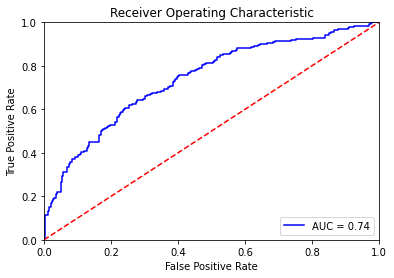

0.7384463961235616

In [6]:
lab1.obs(replace=False)

 Number of candidates 219633
 Number of candidates which will be connected 1027
 Number of candidates which will remain unconnected 218606
Example set is of size 20000


100%|██████████| 20000/20000 [00:09<00:00, 2051.53it/s] 


temporal features calculated


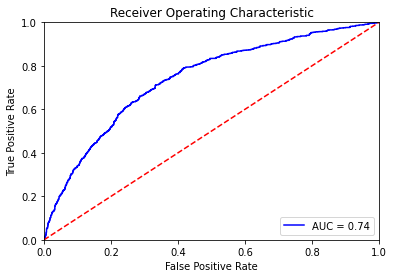

0.7387831766970979

In [10]:
lab1.obs('temporal')

Second graph "rado"

In [41]:
lab2 = GraphAnalyzer(fpath='data/out.radoslaw_email_email')

Total number of edges 82927


100%|██████████| 166/166 [00:00<00:00, 421.41it/s]


In [42]:
lab2.explore_graph()

 Статический граф: 
 Вершин: 167
 Ребер: 3250 
 Плотность: 0.23447081740134187
 Компонент связности: 1
 Доля вершин в максимальной по мощности компоненте связности: 1.0
Honest
 Наибольшая компонента связности: 
 1.Радиус 3
 2.Диаметр 5
 3.90 процентиль расстояния: 3
 Средний кластерный коэффициент: 0.5918632085486949
 Коэффициент ассортативности -0.2951772978930206


 Number of candidates 8101
 Number of candidates which will be connected 262
 Number of candidates which will remain unconnected 7839
Example set is of size 20000


100%|██████████| 20000/20000 [00:00<00:00, 36866.57it/s] 

static features calculated


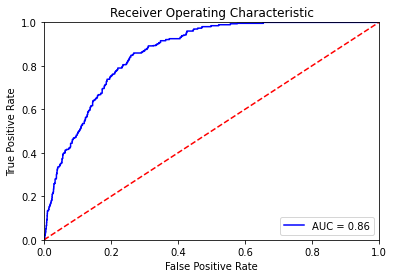

0.8622162618506922

In [43]:
lab2.obs()

In [44]:
lab2.switch_persistence()

Warning. Manually switched to persistent mode. Computations will take significantly shorter but may be less accurate


 Number of candidates 8101
 Number of candidates which will be connected 262
 Number of candidates which will remain unconnected 7839
Example set is of size 20000


100%|██████████| 20000/20000 [00:22<00:00, 877.09it/s]  

temporal features calculated


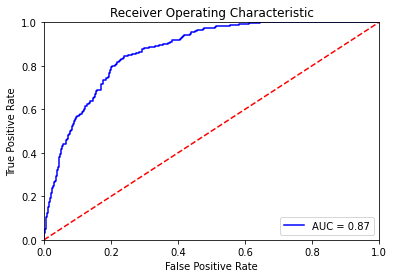

0.8696028767159243

In [45]:
lab2.obs('temporal')

Third graph "bitA"

In [46]:
lab3 = GraphAnalyzer(fpath='data/out.soc-sign-bitcoinalpha')

Total number of edges 24186


100%|██████████| 2776/2776 [00:07<00:00, 383.84it/s]


In [47]:
lab3.explore_graph()

 Статический граф: 
 Вершин: 3783
 Ребер: 14124 
 Плотность: 0.001974375888794159
 Компонент связности: 5
 Доля вершин в максимальной по мощности компоненте связности: 0.9978852762357917
Snowball
 Наибольшая компонента связности: 
 1.Радиус 5.1
 2.Диаметр 9.8
 3.90 процентиль расстояния: 6.7
 Средний кластерный коэффициент: 0.1766290303590767
 Коэффициент ассортативности -0.168515761121504


In [48]:
lab3.switch_persistence()

Warning. Manually switched to persistent mode. Computations will take significantly shorter but may be less accurate


 Number of candidates 290062
 Number of candidates which will be connected 735
 Number of candidates which will remain unconnected 289327
Example set is of size 20000


100%|██████████| 20000/20000 [00:00<00:00, 30504.34it/s]


static features calculated


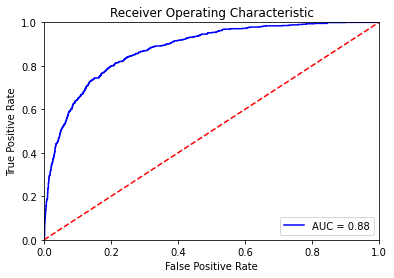

0.8785564605690337

In [49]:
lab3.obs()

 Number of candidates 290062
 Number of candidates which will be connected 735
 Number of candidates which will remain unconnected 289327
Example set is of size 20000


100%|██████████| 20000/20000 [00:09<00:00, 2149.71it/s] 


temporal features calculated


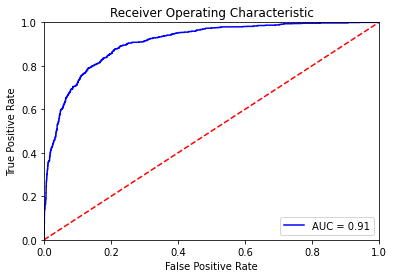

0.9085593918027424

In [50]:
lab3.obs('temporal')

4 graph SX-MO

In [4]:
lab4 = GraphAnalyzer(fpath='data/out.sx-mathoverflow')

Total number of edges 506550


100%|██████████| 15681/15681 [01:20<00:00, 194.01it/s]


In [5]:
lab4.explore_graph()

 Статический граф: 
 Вершин: 24759
 Ребер: 187986 
 Плотность: 0.0006133478457020728
 Компонент связности: 45
 Доля вершин в максимальной по мощности компоненте связности: 0.9963245688436528
Snowball
 Наибольшая компонента связности: 
 1.Радиус 2.8
 2.Диаметр 4.8
 3.90 процентиль расстояния: 3.5
 Средний кластерный коэффициент: 0.31283995486461874
 Коэффициент ассортативности -0.21518125433863328


In [6]:
lab4.switch_persistence()

Warning. Manually switched to persistent mode. Computations will take significantly shorter but may be less accurate


 Number of candidates 13322190
 Number of candidates which will be connected 17612
 Number of candidates which will remain unconnected 13304578
Example set is of size 20000


100%|██████████| 20000/20000 [00:06<00:00, 2977.48it/s]


static features calculated


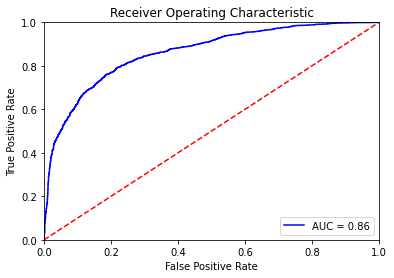

0.86164412912294

In [7]:
lab4.obs()

 Number of candidates 13322190
 Number of candidates which will be connected 17612
 Number of candidates which will remain unconnected 13304578
Example set is of size 20000


100%|██████████| 20000/20000 [05:31<00:00, 60.40it/s] 


temporal features calculated


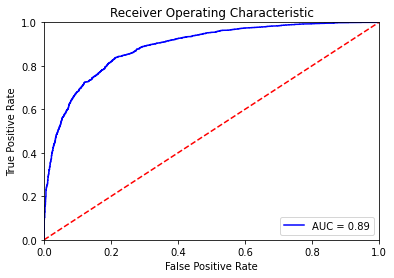

0.8883330445310691

In [8]:
lab4.obs('temporal')